#Import

In [1]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import scipy.io as sio
from matplotlib import pyplot 
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, MaxPooling1D, MaxPooling2D
from keras.models import load_model
from tensorflow.keras import models
from tensorflow import keras
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold

from keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython import display
from sklearn import preprocessing

MODELS_DIR = '/content/drive/MyDrive/Colab/project1_BCI/models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

#Read data & Decode
Emotion Data from https://www.kaggle.com/birdy654/eeg-brainwave-dataset-feeling-emotions

In [76]:
#Read data
data = pd.read_csv("/content/drive/MyDrive/Colab/project1_BCI/Dataset/emotions.csv")
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2132 entries, 0 to 2131
Columns: 2549 entries, # mean_0_a to label
dtypes: float64(2548), object(1)
memory usage: 41.5+ MB
None


In [77]:
#Decode Data
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['label']=le.fit_transform(data['label'])

Label = data.pop('label')
Input = data

In [79]:
#Split Data
Input_train, Input_val_test, Label_train, Label_val = train_test_split(Input, Label, train_size=0.7, random_state=40)

#Training Data Selection, Normalization & Reshape for 2D Conv
Input_train = np.array(Input_train)
Input_train = Input_train[:,545:1274]
Input_train = preprocessing.normalize(Input_train)
Input_train = np.array(Input_train).reshape((Input_train.shape[0],1,Input_train.shape[1],1))

#Validation Data Selection, Normalization & Reshape
Input_val = np.array(Input_val_test)
Input_val = Input_val[:400,545:1274]
Input_val = preprocessing.normalize(Input_val)
Input_val = np.array(Input_val).reshape((Input_val.shape[0],1,Input_val.shape[1],1))

#Test Data Selection, Normalization & Reshape
Input_test = np.array(Input_val_test)
Input_test = Input_test[400:,545:1274]
Input_test = preprocessing.normalize(Input_test)
Input_test = np.array(Input_test).reshape((Input_test.shape[0],1,Input_test.shape[1],1))

Label_train = pd.get_dummies(Label_train)
Label_val = pd.get_dummies(Label_val)
Label_test = Label_val[400:]
Label_val = Label_val[:400]


#Input_train = Input_train[:,545:1274,:]
#Input_val = Input_val[:,545:1274,:]
#Input_train = tf.expand_dims(Input_train, axis=-1)
#Input_val = tf.expand_dims(Input_val, axis=-1)

print("Input_train.shape:")
print(Input_train.shape)

print("\nLabel_train.shape:")
print(Label_train.shape)

print("\nInput_val.shape:")
print(Input_val.shape)

print("\nLabel_train.shape:")
print(Label_val.shape)

print("\nInput_test.shape:")
print(Input_test.shape)

print("\nLabel_test.shape:")
print(Label_test.shape)

Input_train.shape:
(1492, 1, 729, 1)

Label_train.shape:
(1492, 3)

Input_val.shape:
(400, 1, 729, 1)

Label_train.shape:
(400, 3)

Input_test.shape:
(240, 1, 729, 1)

Label_test.shape:
(240, 3)


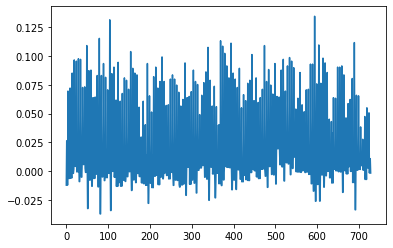

In [80]:
pyplot.plot(Input_train[1,0,:,0])

#Create a model
The result seems highly dependent on the dense layers instead of the conv layers. 

In [81]:
#2D Conv used (supported in Arduino)
model = tf.keras.Sequential()
model.add(layers.Conv2D(filters=6,kernel_size=[1,20],activation='relu', input_shape=(1,Input_train.shape[2],1)))
model.add(layers.Conv2D(filters=6,kernel_size=[1,25],activation='relu'))
model.add(layers.MaxPooling2D(pool_size=[1,30]))
model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.Dense(10,activation='relu')) 
model.add(layers.Dense(3,activation='softmax'))  
#model.add(layers.Dropout(0.3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 1, 710, 6)         126       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 686, 6)         906       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 22, 6)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 22, 6)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 132)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1330      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                

# Fit the model

In [82]:
opt = keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy (), metrics=['accuracy'])

EPOCHS = 200
callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10), ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]# uses validation set to stop training when it start overfitting
history = model.fit(Input_train,Label_train,validation_data=(Input_val,Label_val),epochs=EPOCHS,callbacks=callbacks,batch_size=32, verbose=1, shuffle=True)


Epoch 1/200
47/47 [==============================] - 3s 46ms/step - loss: 0.7419 - accuracy: 0.6696 - val_loss: 0.2847 - val_accuracy: 0.9075
Epoch 2/200
47/47 [==============================] - 2s 42ms/step - loss: 0.2745 - accuracy: 0.8954 - val_loss: 0.2756 - val_accuracy: 0.9025
Epoch 3/200
47/47 [==============================] - 2s 42ms/step - loss: 0.2352 - accuracy: 0.9135 - val_loss: 0.2334 - val_accuracy: 0.9100
Epoch 4/200
47/47 [==============================] - 2s 42ms/step - loss: 0.2255 - accuracy: 0.9075 - val_loss: 0.2289 - val_accuracy: 0.9100
Epoch 5/200
47/47 [==============================] - 2s 42ms/step - loss: 0.2152 - accuracy: 0.9122 - val_loss: 0.1961 - val_accuracy: 0.9200
Epoch 6/200
47/47 [==============================] - 2s 42ms/step - loss: 0.2055 - accuracy: 0.9135 - val_loss: 0.1769 - val_accuracy: 0.9225
Epoch 7/200
47/47 [==============================] - 2s 42ms/step - loss: 0.1961 - accuracy: 0.9182 - val_loss: 0.1856 - val_accuracy: 0.9200
Epoch 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab/project1_BCI/models/model/assets


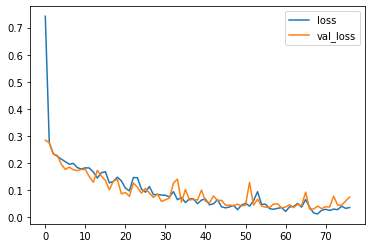

In [83]:

model = load_model('./best_model.h5')
model.save(MODEL_TF)
#model.save('/content/drive/MyDrive/Colab/project1_BCI/best_model.h5')
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

# Model Conversion

In [84]:
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)
def representative_dataset():
  for i in range(500):
    yield([Input_train[i,:,:,:].reshape(1,1,Input_train.shape[2],1).astype(np.float32)])

# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

6224

In [85]:
# Calculate size
size_no_quant_tflite = os.path.getsize(MODEL_NO_QUANT_TFLITE)
size_tflite = os.path.getsize(MODEL_TFLITE)

# Compare size
# Compare size
pd.DataFrame.from_records(
    [["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {0} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")

Size                         
Model                                                           
TensorFlow Lite            12524 bytes      (reduced by 0 bytes)
TensorFlow Lite Quantized    6224 bytes  (reduced by 6300 bytes)

In [86]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

# Software Testing

In [87]:
#Test function
def predict_tflite(tflite_model, x_test):
  # Prepare the test data
  x_test_ = x_test.copy()
  #x_test_ = x_test_.reshape((x_test.size, 1))
  x_test_ = x_test_.astype(np.float32)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    x_test_ = x_test_ / input_scale + input_zero_point
    x_test_ = x_test_.astype(input_details["dtype"])
  # Invoke the interpreter
  interpreter.set_tensor(input_details["index"], x_test_)
  interpreter.invoke()
  y_pred = interpreter.get_tensor(output_details["index"])[0]
  
  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    y_pred = y_pred.astype(np.float32)
    y_pred = (y_pred - output_zero_point) * output_scale

  return y_pred


In [88]:
print("Input_test.shape:")
print(Input_test.shape)

print("\nLabel_test.shape:")
print(Label_test.shape)

Input_test.shape:
(240, 1, 729, 1)

Label_test.shape:
(240, 3)


In [90]:
# Calculate predictions with full software

# Calculate predictions with full software
y_pred = np.reshape(np.argmax(model.predict(Input_test), axis=1),[len(Input_test),1])
y_true = np.reshape(np.argmax(np.array(Label_test), axis=1),[len(Label_test),1])

test_acc = float(sum(y_pred == y_true) / len(y_true))
print('Test accuracy with model:')
print(f"{test_acc:.2%}")
y_test_pred_no_quant_tflite=np.empty([Input_test.shape[0],1])
y_test_pred_tflite=np.empty([Input_test.shape[0],1])
# Calculate predictions with tensorflow lite
for i in range(0,Input_test.shape[0]):
  y_test_pred_no_quant_tflite[i,0]=np.argmax(predict_tflite(model_no_quant_tflite, Input_test[i:i+1,:,:,:]))

test_acc = float(sum(y_test_pred_no_quant_tflite == y_true) / len(y_true))
print('Test accuracy with model tf lite:')
print(f"{test_acc:.2%}")


# Calculate predictions with tensorflow lite quantized model
for i in range(0,Input_test.shape[0]):
  y_test_pred_tflite[i,0]=np.argmax(predict_tflite(model_tflite, Input_test[i:i+1,:,:,:]))

test_acc = float(sum(y_test_pred_tflite == y_true) / len(y_true))
print('Test accuracy with model quantized:')
print(f"{test_acc:.2%}")


Test accuracy with model:
99.58%
Test accuracy with model tf lite:
99.58%
Test accuracy with model quantized:
99.58%


In [94]:
#Write files for arduino test
#Calculate predictions with tensorflow lite quantized model
y_test_pred_tflite=np.empty([Input_test.shape[0],3])
for i in range(0,Input_test.shape[0]):
  y_test_pred_tflite[i,:]=(predict_tflite(model_tflite, Input_test[i:i+1,:,:,:]))
y_true = Label_test

y_test_tflite = {"y_test_pred_tflite":y_test_pred_tflite}
sio.savemat('/content/drive/MyDrive/Colab/project1_BCI/models',y_test_tflite)